Setup and installation



In [32]:
!pip install cohere google-generativeai pillow tqdm PyMuPDF chromadb langchain langchain-google-genai

API Key Setup

In [33]:
import cohere
from google import generativeai as genai

from google.colab import userdata

cohere_api_key = userdata.get('COHERE')
gemini_api_key = userdata.get('GEMINI')

# Authenticate clients
co = cohere.ClientV2(api_key=cohere_api_key)
genai.configure(api_key=gemini_api_key)

Upload and Import PDF

In [41]:
from google.colab import files
uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]
print(f"✅ Uploaded PDF: {pdf_path}")

Saving GRP 13_MPR_REPORT_SEM 8 (1).pdf to GRP 13_MPR_REPORT_SEM 8 (1).pdf
✅ Uploaded PDF: GRP 13_MPR_REPORT_SEM 8 (1).pdf


PDF - Text and Image Extraction

In [42]:
import os
image_folder = "/content/pdf_images"
os.makedirs(image_folder, exist_ok=True)

In [43]:
import fitz
text_chunks = []
image_paths = []

doc = fitz.open(pdf_path)

for page_num in range(len(doc)):
  page = doc[page_num]
  text = page.get_text()
  if text.strip():
    text_chunks.append(text)

  images = page.get_images(full=True)
  for img_index, img in enumerate(images):
    xref = img[0] #img[0] is the XREF (cross-reference number) of the image in the PDF.
    base_image = doc.extract_image(xref) # From doc we get image details
    image_bytes = base_image["image"]
    img_ext = base_image["ext"]
    img_filename = f"page{page_num+1}_img{img_index+1}.{img_ext}"
    img_path = os.path.join(image_folder, img_filename)

    with open(img_path, "wb") as f:
        f.write(image_bytes)
    image_paths.append(img_path)

print(f"✅ Extracted {len(text_chunks)} text chunks and {len(image_paths)} images")


✅ Extracted 19 text chunks and 6 images


Image Encoding - BASE64

In [44]:
from PIL import Image
import base64
import io

max_pixels = 1600 * 1600

def resize_image(pil_image):
    org_width, org_height = pil_image.size
    if org_width * org_height > max_pixels:
        scale_factor = (max_pixels / (org_width * org_height)) ** 0.5
        new_width = int(org_width * scale_factor)
        new_height = int(org_height * scale_factor)
        pil_image.thumbnail((new_width, new_height))

def base64_from_image(img_path):
    pil_image = Image.open(img_path).convert("RGB")
    resize_image(pil_image)
    with io.BytesIO() as img_buffer:
        pil_image.save(img_buffer, format="PNG")
        img_buffer.seek(0)
        return "data:image/png;base64," + base64.b64encode(img_buffer.read()).decode("utf-8")

ChromaDB vector store

In [45]:
import chromadb
from chromadb.config import Settings

chroma_client = chromadb.PersistentClient(path="/content/chroma_db")
collection = chroma_client.get_or_create_collection(name="multimodal_embeddings")

Embeddings - Text and Images store embeddings

In [46]:

# Store Embeddings (Text + Image)
import uuid
from tqdm import tqdm

# Store text embeddings
for i, chunk in tqdm(enumerate(text_chunks), desc="Storing Text"):
    res = co.embed(
        model="embed-v4.0",
        input_type="search_document",
        embedding_types=["float"],
        texts=[chunk]
    )
    emb = res.embeddings.float[0]
    collection.add(
        ids=[f"text_{uuid.uuid4()}"],
        embeddings=[emb],
        documents=[chunk],
        metadatas=[{"type": "text"}]
    )

# Store image embeddings
for img_path in tqdm(image_paths, desc="Storing Images"):
    base64_img = base64_from_image(img_path)
    api_input = {"content": [{"type": "image", "image": base64_img}]}
    res = co.embed(
        model="embed-v4.0",
        input_type="search_document",
        embedding_types=["float"],
        inputs=[api_input]
    )
    emb = res.embeddings.float[0]
    collection.add(
        ids=[f"image_{uuid.uuid4()}"],
        embeddings=[emb],
        documents=[img_path],
        metadatas=[{"type": "image"}]
    )


Storing Text: 19it [00:02,  8.63it/s]
Storing Images: 100%|██████████| 6/6 [00:01<00:00,  3.89it/s]


LCEL Chain and model structure

In [47]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnablePassthrough

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.3,
    google_api_key = gemini_api_key
)


prompt_template = ChatPromptTemplate.from_messages([
    ("ai", "You are a helpful AI that answers questions using only the provided context."),
    ("human", "Answer the following question:\nQuestion: {question}\n\nContext:\n{context}")
])

# LCEL Chain with Prompt Template
response_chain = (
    RunnablePassthrough()
    | (lambda inputs: {"question": inputs["question"], "context": inputs["context"]})
    | prompt_template
    | llm
    | StrOutputParser()
)

Query Embedding and Search Retrival Process

In [48]:
def query_retrival(question, top_k=2):
    # Query embedding
    q_res = co.embed(
        model="embed-v4.0",
        input_type="search_query",
        embedding_types=["float"],
        texts=[question]
    )
    query_emb = q_res.embeddings.float[0]

    # Query ChromaDB
    results = collection.query(
        query_embeddings=[query_emb],
        n_results=top_k * 2
    )

    top_texts, top_imgs = [], []
    for doc, meta in zip(results['documents'][0], results['metadatas'][0]):
        if meta["type"] == "text":
            top_texts.append(doc)
        elif meta["type"] == "image":
            top_imgs.append(doc)

    top_texts = top_texts[:top_k]
    top_imgs = top_imgs[:top_k]

    # Prepare context string (text + image)
    context = "\n\n".join(
        top_texts + [f"[IMAGE: {img}]" for img in top_imgs]
    )

    # Call LangChain LCEL chain
    response_text = response_chain.invoke({"question": question, "context": context})
    return response_text, top_imgs

Display Data

LLM Model Answer:
A Convolutional Neural Network (CNN) is an architecture designed to extract hierarchical features from images, in this context, from plant leaf images for disease detection.

The CNN architecture described comprises the following layers:

*   **Input Layer:** This layer accepts the leaf images as input, typically in RGB format.
*   **Convolutional Layers:** These layers extract features from the input using convolution operations. They are followed by activation functions, such as ReLU, to introduce non-linearity.
*   **Pooling Layers:** These layers downsample the feature maps, which helps in capturing important features while simultaneously reducing computational complexity.
*   **Flattening Layer:** This layer converts the 2D feature maps into a 1D vector, preparing them for input to the fully connected layers.
*   **Fully Connected Layers:** These layers perform classification based on the features extracted by the preceding layers, typically concluding with a sof

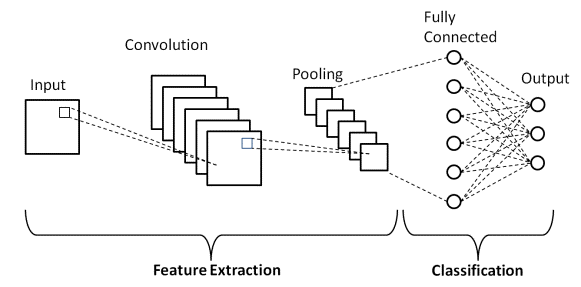

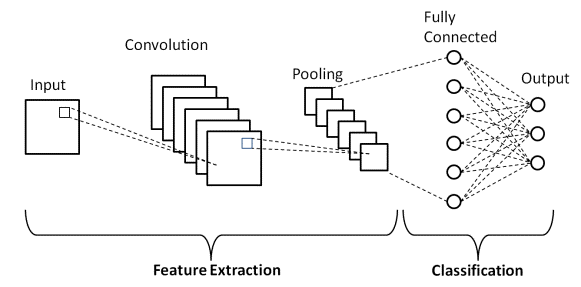

In [49]:
from IPython.display import display

question = "Explain me Convolutional Neural Network (CNN) with diagram?"
answer_text, result_images = query_retrival(question)

print("LLM Model Answer:")
print(answer_text)

for img in result_images:
    display(Image.open(img))

In [50]:
question = "Explain DCGAN?"
answer_text, result_images = query_retrival(question)

print("LLM Model Answer:")
print(answer_text)

for img in result_images:
    display(Image.open(img))

LLM Model Answer:
DCGAN (Deep Convolutional Generative Adversarial Networks) is an architecture composed of two networks, the generator and the discriminator, which engage in an adversarial training process.

Here's how each network functions:
*   **Generator Network:** This network generates synthetic images (specifically, realistic leaf images in the provided context) from random noise vectors. It uses transposed convolutional layers and activation functions like ReLU or tanh.
*   **Discriminator Network:** This network's role is to distinguish between real images and the images generated by the generator. It employs convolutional layers followed by activation functions and a final output layer for binary classification.
